In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.70826063200002
GPU (s):
0.18529664400000456
GPU speedup over CPU: 46x


In [4]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a0bc000 @  0x7f7c0f31c1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 1.6MB/s 
    100% |████████████████████████████████| 2.0MB 2.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

In [0]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1 X 1
        
        self.b = torch.zeros(1, n_neurons) # 1 X 4
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # 4 X 1
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # 4 X 1
        
        return self.Y0, self.Y1

In [0]:
N_INPUT = 4
N_NEURONS = 4

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [11]:
print(Y0_val)
print(Y1_val)

tensor([[-0.9964, -0.8168, -0.9679,  0.9723],
        [-1.0000, -1.0000, -0.9983,  1.0000],
        [-1.0000, -1.0000, -0.9999,  1.0000],
        [-0.9922, -0.9991,  0.9996,  0.9999]])
tensor([[-1.0000, -1.0000, -1.0000,  1.0000],
        [-0.3337,  0.7074, -0.9980,  0.1663],
        [-1.0000, -1.0000, -0.9997,  1.0000],
        [-0.9934, -1.0000, -0.9877,  0.9998]])


In [9]:
rnn = nn.RNNCell(3, 5) # n_input X n_neurons

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5) # m X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[-0.5609, -0.4882,  0.6137, -0.7312, -0.6829],
        [-0.9333,  0.9847,  0.4334, -0.2664, -0.8751],
        [-0.9733,  0.8823,  0.2945,  0.9724, -0.8386],
        [-0.9092,  0.9905,  0.9739,  0.9975, -0.1721]],
       grad_fn=<TanhBackward>), tensor([[-0.9812,  0.9989, -0.4505,  0.9913, -0.9749],
        [-0.2883, -0.0724, -0.1285, -0.1766, -0.3058],
        [-0.5450,  0.9473,  0.0605,  0.9486, -0.9414],
        [-0.0264,  0.5456, -0.0370,  0.7391, -0.7211]],
       grad_fn=<TanhBackward>)]


In [12]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contains values for final state or final timestep, i.e., t=1

[tensor([[-0.8331,  0.9408, -0.6335,  0.1215, -0.8179],
        [-0.9237,  0.9755,  0.7108, -0.5914, -0.9381],
        [-0.9879,  0.9947,  0.0420,  0.9072, -0.9768],
        [-0.9714,  0.9999,  0.7836,  0.9972, -0.8023]],
       grad_fn=<TanhBackward>), tensor([[-0.8813,  0.9985,  0.1911,  0.9767, -0.9940],
        [-0.4646, -0.0743, -0.2383, -0.1385, -0.2264],
        [-0.5136,  0.9528,  0.1040,  0.9381, -0.9499],
        [-0.0427,  0.4385, -0.0723,  0.7670, -0.6757]],
       grad_fn=<TanhBackward>)]
tensor([[-0.8813,  0.9985,  0.1911,  0.9767, -0.9940],
        [-0.4646, -0.0743, -0.2383, -0.1385, -0.2264],
        [-0.5136,  0.9528,  0.1040,  0.9381, -0.9499],
        [-0.0427,  0.4385, -0.0723,  0.7670, -0.6757]],
       grad_fn=<TanhBackward>)


In [13]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Processing...
Done!


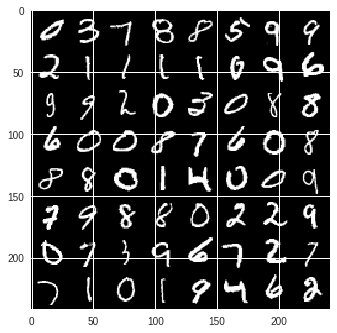

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [0]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [19]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0353,  0.0563, -0.0293, -0.0251, -0.0048, -0.0494, -0.0401, -0.0175,
         -0.0329,  0.0756],
        [-0.0302,  0.0583, -0.0195, -0.0227, -0.0066, -0.0491, -0.0330, -0.0217,
         -0.0342,  0.0826],
        [-0.0321,  0.0574, -0.0164, -0.0242, -0.0022, -0.0510, -0.0354, -0.0219,
         -0.0323,  0.0826],
        [-0.0335,  0.0566, -0.0179, -0.0220, -0.0021, -0.0509, -0.0378, -0.0215,
         -0.0319,  0.0828],
        [-0.0313,  0.0560, -0.0247, -0.0280, -0.0041, -0.0504, -0.0386, -0.0199,
         -0.0308,  0.0797],
        [-0.0183,  0.0574, -0.0591, -0.0154, -0.0336, -0.0655, -0.0463, -0.0093,
         -0.0139,  0.0801],
        [-0.0333,  0.0512, -0.0143, -0.0205, -0.0007, -0.0504, -0.0374, -0.0188,
         -0.0363,  0.0782],
        [-0.0305,  0.0422, -0.0361, -0.0163, -0.0184, -0.0662, -0.0479, -0.0120,
         -0.0293,  0.0789],
        [-0.0333,  0.0566, -0.0146, -0.0239, -0.0032, -0.0474, -0.0332, -0.0180,
         -0.0293,  0.0822],
        [-0.0321,  

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8f18b30390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()


In [22]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7592 | Train Accuracy: 74.43
Epoch:  1 | Loss: 0.3344 | Train Accuracy: 89.70
Epoch:  2 | Loss: 0.2445 | Train Accuracy: 92.50
Epoch:  3 | Loss: 0.1933 | Train Accuracy: 93.98
Epoch:  4 | Loss: 0.1653 | Train Accuracy: 94.79
Epoch:  5 | Loss: 0.1426 | Train Accuracy: 95.47
Epoch:  6 | Loss: 0.1362 | Train Accuracy: 95.65
Epoch:  7 | Loss: 0.1367 | Train Accuracy: 95.50
Epoch:  8 | Loss: 0.1155 | Train Accuracy: 96.21
Epoch:  9 | Loss: 0.1149 | Train Accuracy: 96.25


In [23]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))


Test Accuracy: 96.34
